# Projet de transport optimal CMI 2023/2024

L'objectif de ce projet est de travailler autour de la recolorisation d'une image à l'aide du transport optimal. 

Ce travail se divise en trois étapes différentes : 
* Recolorisation d'une vidéo à partir d'une image référence. Chaque image de la vidéo sera recolorisée par la même image cible. 
* Recolorisation d'une vidéo à partir d'une image référence. Cette fois-ci, l'hypothèse de dépendance des images d'une même vidéo sera considérée et la recolorisation des images se fera donc en fonction. 
* Modification du style d'une image via des réseaux de neurones convolutionnels (optionnel). 


### Libraries à importer/utiliser

ATTENTION: TensorFlow ne supporte pas python 3.12. Mieux vaut travailler sur python 3.11

In [1]:
%%capture

%pip install POT
%pip install tensorflow
%pip install opencv-python

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import ot
import cv2
import sklearn.cluster as skcluster
import time

rng = np.random.RandomState(1)

## Fonctions

### Fonctions manipulation d'image

In [3]:
def im2mat(img):
    """
    Convertie une image en matrice (un pixel par ligne)
    Entrée: - img(matrix): Image que l'on cherche à transformer en matrice
    Sortie: Matrice obtenue après le reshape
    """
    return img.reshape((img.shape[0] * img.shape[1], img.shape[2]))


def mat2im(X, shape):
    """
    Convertie une matrice en image
    Entrées: - X(matrice): Matrice que l'on veut convertir en image
             - shape(list): Dimensions de l'image attendue
    Sortie: Image obtenue
    """
    return X.reshape(shape)

def minmax(img):
    """
    Limite les valeurs de l'image entre 0 et 1. 
    Entrée: - img(matrice): Image à modifier
    Sortie: - np.clip(img,0,1)(matrice): Image avec des valeurs uniquement entre 0 et 1
    """
    return np.clip(img, 0, 1)

### Fonction liées à la récupération d'images et de vidéo

In [4]:
def import_image(path):
    """
    Importe une image et récupère sa matrice
    Entrée: - path(str): Chemin de l'image
    Sorties: - img(matrix): Image obtenue
             - mat(matrix): Matrice de l'image
    """
    img = plt.imread(path).astype(np.float64)/256
    mat = im2mat(img)
    return img, mat


def extract_frames(path):
    """
    Récupère les images d'une vidéo
    Entrée: - path(str): Chemin pour accéder à la vidéo
    Sortie: - frames(list): Liste des images qui composent la vidéo
    """
    cap = cv2.VideoCapture(path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # récupère les images en RGB
        frames.append(frame_rgb.astype(np.float64) / 256)

    cap.release() # libère cap

    return frames


def create_video(frames, video_name, path):
    """
    Création d'une vidéo (.avi) à partir d'une liste de photos (nupy array)
    Entrées: - frames (numpy list of image's pixels): Images that we want to use for the creation of the video
             - video_name (str): Name of the video (don't put the .avi)
             - path (str): path of the video
    
    """
    height, width, layers = frames[0].shape
    print(frames[0].shape)
    fourcc = cv2.VideoWriter_fourcc(*'DIVX') 
    video = cv2.VideoWriter(path+"/"+video_name+".avi", fourcc, 30, (width, height))

    for frame in frames:
        video.write((frame * 255).astype(np.uint8))  # Mettre à l'échelle de 0-1 à 0-255 pour écrire la vidéo

    cv2.destroyAllWindows()
    video.release()

### Fonctions d'affichage

In [5]:
def plot_distribution(X, title):
    """
    Affiche la distribution des couleurs de la matrice en paramètre
    Entrées: - X(matrice): Matrice de l'image étudiée
             - title(str): Titre du graphe
    """
    plt.scatter(X[:, 0], X[:, 2], c=X)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Red')
    plt.ylabel('Blue')
    plt.title(title)
    plt.show()

def print_image(img, title):
    """
    Affiche l'image dans l'API utilisée
    Entrées: - img(matrix): Image à afficher
             - title(str): Titre de l'image 
    """
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)

### Fonctions transport optimal

In [6]:
def clustering(X, model_clust):
    """
    Applique un clustering sur deux matrices d'images (Les valeurs de X doivent être entre 0 et 1).
    Entrées: - X1(matrice): Matrice de la première image
             - model_clust(model scikit learn): Modèle de clustering
    Sortie: - Xs(matrice): Matrice après le clustering
    """
    clust1 = model_clust.fit(X)
    Xs = np.clip(clust1.cluster_centers_,0,1) 
    return Xs


def train_tran_opt(Xs, Xt, method):
    """
    Entraîne un modèle de transport optimal sur les données Xs et Xt.
    Entrées: - Xs(matrice): Matrice à colorer pour l'entraînement (mieux si clustering en amont)
             - Xt(matrice): Matrice référence pour l'entraînement (mieux si clustering en amont)
             - method(str): Modèle de transport optimal utilisé 
    Sortie: - ot_model(model OT): Modèle de transport optimal entraîné
    """
    if method == "emd":
        ot_model = ot.da.EMDTransport()
    elif method == "sinkhorn":
        ot_model = ot.da.SinkhornTransport(reg_e=1e-1)
    elif method == "linear":
        ot_model = ot.da.MappingTransport(
            mu=1e0, eta=1e-8, bias=True, max_iter=20, verbose=True)
    elif method == "gaussian":
        ot_model = ot.da.MappingTransport(
            mu=1e0, eta=1e-2, sigma=1, bias=False, max_iter=10, verbose=True)
    else:
        print("Les quatres choix de modèles sont : \n- 'emd' : EMDTransport \n- 'sinkhorn': SinkhornTransport \n- 'linear': Mapping linéaire \n- 'gaussian': Mapping Gaussien")
        return None
        
    ot_model.fit(Xs=Xs, Xt=Xt)
    return ot_model

def color_image(X, ot_model, img_shape):
    """
    Recolorise une image X à partir d'un modèle d'optimal transport entraîné
    Entrées: - X (matrice): Image à recolorer
             - ot_model (model OT): Modèle de transport optimal entraîné
             - img_shape (vector): Dimensions de l'image X
    Sortie: - img (matrice): Image recolorée
    """
    transp_Xs = ot_model.transform(Xs=X)
    img = minmax(mat2im(transp_Xs, img_shape))
    return img

## Données utilisées

### Image référence

Lien de la photo : https://www.pexels.com/fr-fr/photo/cadre-de-batiment-sureleve-169647/

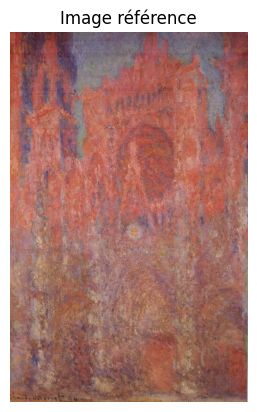

In [19]:
path_ref = './photos/cathedrale_rouen_monet/La Cathédrale de Rouen.jpg'
img_ref, mat_ref = import_image(path_ref)

print_image(img_ref, "Image référence")

### Vidéo étudiée

In [20]:
video_path = './videos/short_city.mp4'
frames = extract_frames(video_path)

if frames is not None:
    print(f"Number of frames extracted: {len(frames)}")
else:
    print("Error extracting frames.")

Number of frames extracted: 30


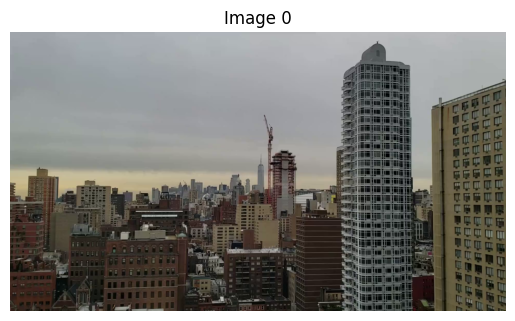

In [21]:
print_image(frames[0], 'Image 0')

In [10]:
# print_image(frames[100], 'Image 100')

In [11]:
# print_image(frames[200], 'Image 200')

## Transfert optimal

### Test pour une image

In [12]:
# Fonction du transport optimal pour une image

def ot_one_image(img_target, img_ref, model_clust, model_ot_type="emd"):
    """
    Réalise le transport optimal pour une seule image à partir d'une image de référence
    Entrées: - img_target (image): Image que l'on veut recoloriser
             - img_ref (image): Image de référence
             - model_clust (modèle de clustering): Modèle utilisé pour le clustering sur les données
             - model_ot_type (modèle de transport optimal): Modèle de transport optimal utilisé. 

    Sorties: - img_col (img): Image recolorisée
             - Xs (mat): Matrice contenant l'image target après clustering
             - Xt (mat): Matrice contenant l'image de rréférence après clustering
             - ot_model: model de transport optimal après clustering

    """
    start = time.time()
    # get matrix
    mat_target = im2mat(img_target); mat_ref=im2mat(img_ref)

    # clustering
    Xs = clustering(mat_target, model_clust)
    Xt = clustering(mat_ref, model_clust)
    end_clust=time.time()

    # train model
    ot_model = train_tran_opt(Xs,Xt,model_ot_type)
    end_train = time.time()

    # get colored image
    mat_col = color_image(Xs, ot_model, Xs.shape)
    end_color = time.time()

    img_col = mat2im(mat_col[model_clust.predict(mat_target),:],img_target.shape)

    print("Temps de clustering (2 images): ", end_clust-start)
    print("Temps de train: ", end_train-end_clust)
    print("Temps de color: ", end_color-end_train)

    return img_col, mat_col, Xs, Xt, ot_model

In [22]:
# initialisation des variables

nb_samples = 1000
img_target = frames[0]; #img_ref = img_ref (pour ne pas oublier qu'il faut l'implementer)
model_clust = skcluster.MiniBatchKMeans(n_clusters=nb_samples, init_size = 3000, random_state=2) # random_state pour gérer l'aléaroire

# appel de la fonction

(img_col, mat_col, Xs, Xt, ot_model) = ot_one_image(img_target, img_ref, model_clust)

Temps de clustering (2 images):  61.04177236557007
Temps de train:  0.2010056972503662
Temps de color:  0.009968042373657227


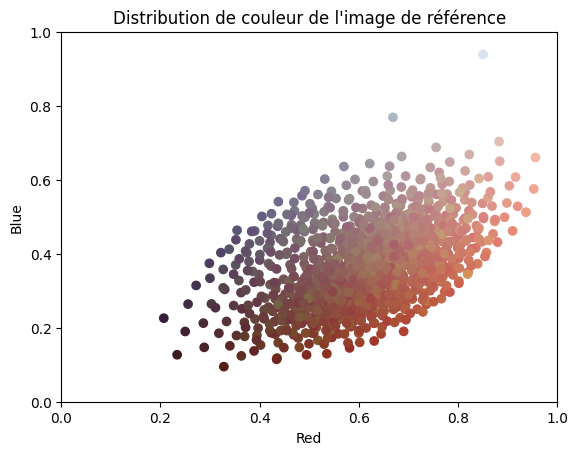

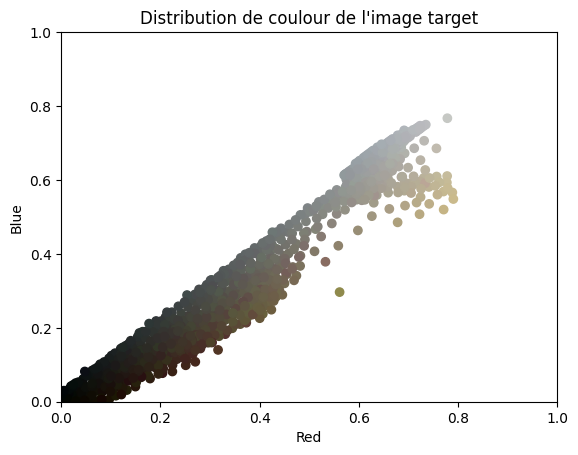

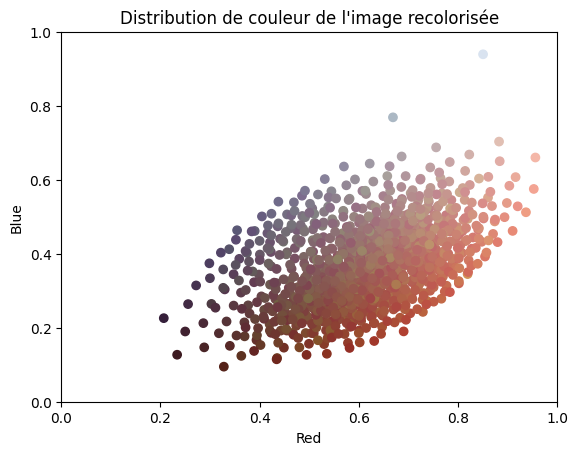

In [23]:
plot_distribution(Xt, "Distribution de couleur de l'image de référence")
plot_distribution(Xs, "Distribution de coulour de l'image target")
plot_distribution(mat_col, "Distribution de couleur de l'image recolorisée")

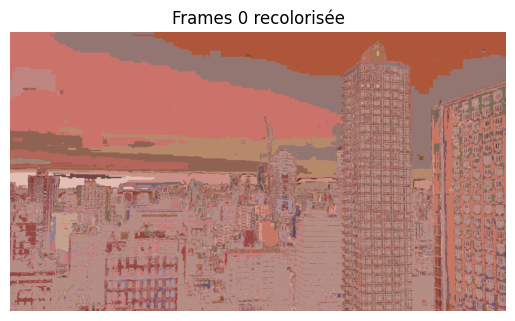

In [24]:
print_image(img_col, "Frames 0 recolorisée")

### Transport optimal pour toute la vidéo avec une seule image référence

In [25]:
def ot_img_ref(frames, img_ref, model_clust, model_ot_type="emd"):
    """
    Récupère une série d'images et une image de référence, entraîne un modèle de transport optimal sur la première image de la liste et
    l'image de référence (après clustering). Applique le modèle à toutes les images de la liste
    Entrées: - frames (liste): Liste d'image à recoloriser
             - img_ref (img): image référence
             - model_clust (scikit model): Modèle de clustering
             - model_ot_type(str): Type du modèle de transport optimal
    """
    # get matrix
    mat_target = im2mat(frames[0]); mat_ref=im2mat(img_ref)

    # clustering
    Xs = clustering(mat_target, model_clust)
    Xt = clustering(mat_ref, model_clust)

    # train model
    ot_model = train_tran_opt(Xs,Xt,model_ot_type)

    colored_images = []
    for count, frame in enumerate(frames):
        mat_img = im2mat(frame)
        X = clustering(mat_img, model_clust)
        mat_col = color_image(X, ot_model, X.shape)
        img_col = mat2im(mat_col[model_clust.predict(mat_img),:],frame.shape)
        colored_images.append(img_col)
        print(f"Recolorisation de la {count + 1}ème image.")

    return colored_images, Xs, Xt, ot_model
        

In [26]:
# initialisation des variables

nb_samples = 1000
model_clust = skcluster.MiniBatchKMeans(n_clusters=nb_samples, init_size = 3000, random_state=2) # random_state pour gérer l'aléaroire

# appel de la fonction

(colored_frames, Xs, Xt, ot_model) = ot_img_ref(frames, img_ref, model_clust)

Recolorisation de la 1ème image.
Recolorisation de la 2ème image.
Recolorisation de la 3ème image.
Recolorisation de la 4ème image.
Recolorisation de la 5ème image.
Recolorisation de la 6ème image.
Recolorisation de la 7ème image.
Recolorisation de la 8ème image.
Recolorisation de la 9ème image.
Recolorisation de la 10ème image.
Recolorisation de la 11ème image.
Recolorisation de la 12ème image.
Recolorisation de la 13ème image.
Recolorisation de la 14ème image.
Recolorisation de la 15ème image.
Recolorisation de la 16ème image.
Recolorisation de la 17ème image.
Recolorisation de la 18ème image.
Recolorisation de la 19ème image.
Recolorisation de la 20ème image.
Recolorisation de la 21ème image.
Recolorisation de la 22ème image.
Recolorisation de la 23ème image.
Recolorisation de la 24ème image.
Recolorisation de la 25ème image.
Recolorisation de la 26ème image.
Recolorisation de la 27ème image.
Recolorisation de la 28ème image.
Recolorisation de la 29ème image.
Recolorisation de la 30

In [28]:
# Création de la vidéo

create_video(colored_frames, "cath_video", "./")


(1080, 1920, 3)
